In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import copy

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})
def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

import random


Processing ggHH...
Found 5 files for ggHH
  [5/5] Processing ensemble_method2_ggHH_id800-999.root

Total events collected: 94091
Total weight: 44.53
Sampling 30.0% of events for plotting: 28227 events


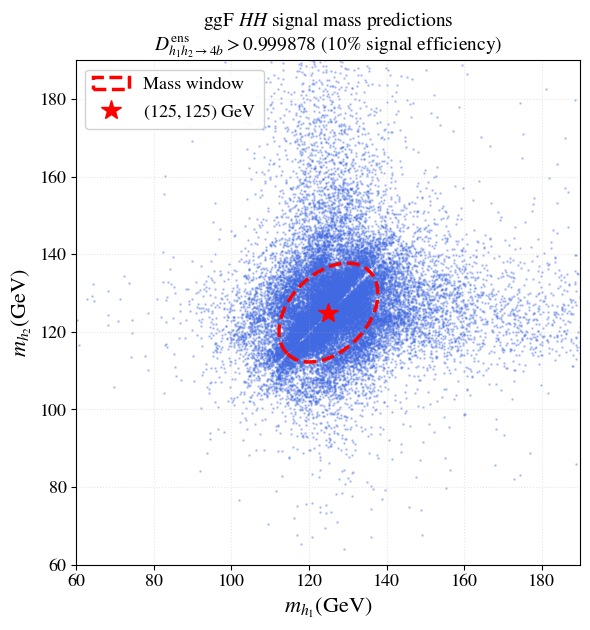


Scatter plot saved as cut0p999878_ggHH_scatter.png and cut0p999878_ggHH_scatter.pdf

Events inside ellipse: 52694 (56.0%)
Weighted events inside: 24.94 (56.0%)


In [11]:
import numpy as np
import awkward as ak
import uproot
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

# ===== Configuration =====
ntuple_base_dir = "/data/bond/tyyang99/HH4b/ensemble_method2_ntuples_cdfv2"

lumi_scale = 4.5  # 450 fb^-1

weight_dict = {
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
}

cut_value = 0.999878
cut_name = f"cut{str(cut_value).replace('.','p')}"

discriminant = 'score_hh4bvsboth'

proc_name = 'ggHH'
# proc_name = 'QCD'

# Ellipse parameters
a_param = 15  # semi-major axis
b_param = 2/3 * a_param     # semi-minor axis
center_x = 125
center_y = 125

# ===== Sampling parameter =====
# Fraction of events to plot (0 < sample_fraction <= 1)
sample_fraction = 0.3  # Plot 30% of events for better visualization
# sample_fraction = 1  # Plot 30% of events for better visualization

# ===== Process ggHH signal =====
print(f"\n{'='*80}")
print(f"Processing {proc_name}...")
print(f"{'='*80}")

proc_dir = os.path.join(ntuple_base_dir, proc_name)

if not os.path.exists(proc_dir):
    print(f"Warning: Directory not found for {proc_name}")
else:
    all_x_final = []
    all_y_final = []
    all_weights = []
    
    weight = weight_dict[proc_name]
    
    ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
    
    print(f"Found {len(ntuple_files)} files for {proc_name}")
    
    for f_id, ntuple_file in enumerate(ntuple_files):
        try:
            print(f"\r  [{f_id+1}/{len(ntuple_files)}] Processing {os.path.basename(ntuple_file)}", end='')
            
            with uproot.open(ntuple_file) as f:
                tree = f["tree"]
                data = tree.arrays([
                    f'model0_{discriminant}',
                    f'model1_{discriminant}',
                    f'model2_{discriminant}',
                    'combined_basic_fit_cut',
                    'ensemble_final_peak_x',
                    'ensemble_final_peak_y',
                    'weight'
                ])
            
            cut_mask = data['combined_basic_fit_cut'] == 1
            
            if ak.sum(cut_mask) == 0:
                continue
            
            scores_model0 = data[f'model0_{discriminant}'][cut_mask]
            scores_model1 = data[f'model1_{discriminant}'][cut_mask]
            scores_model2 = data[f'model2_{discriminant}'][cut_mask]
            
            ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
            
            score_cut = ensemble_scores > cut_value
            
            if ak.sum(score_cut) == 0:
                continue
            
            peak_x_final = ak.to_numpy(data['ensemble_final_peak_x'][cut_mask][score_cut])
            peak_y_final = ak.to_numpy(data['ensemble_final_peak_y'][cut_mask][score_cut])
            event_weights = ak.to_numpy(data['weight'][cut_mask][score_cut])
            
            # Apply mass range cut
            p1_cut = (peak_x_final >= 40) & (peak_x_final <= 200) & (peak_y_final >= 40) & (peak_y_final <= 200)
            
            peak_x_final = peak_x_final[p1_cut]
            peak_y_final = peak_y_final[p1_cut]
            event_weights = event_weights[p1_cut]
            
            if len(peak_x_final) > 0:
                all_x_final.append(peak_x_final)
                all_y_final.append(peak_y_final)
                all_weights.append(event_weights)
                
        except Exception as e:
            print(f"\n    Error processing {ntuple_file}: {e}")
            continue
    
    print()  # New line after progress
    
    if all_x_final:
        x_final = np.concatenate(all_x_final)
        y_final = np.concatenate(all_y_final)
        weights = np.concatenate(all_weights)
        
        total_events = len(x_final)
        print(f"\nTotal events collected: {total_events}")
        print(f"Total weight: {np.sum(weights):.2f}")
        
        # ===== Sample events for plotting =====
        if sample_fraction < 1.0:
            np.random.seed(42)  # for reproducibility
            n_sample = int(total_events * sample_fraction)
            sample_indices = np.random.choice(total_events, size=n_sample, replace=False)
            
            x_final_plot = x_final[sample_indices]
            y_final_plot = y_final[sample_indices]
            
            print(f"Sampling {sample_fraction*100:.1f}% of events for plotting: {n_sample} events")
        else:
            x_final_plot = x_final
            y_final_plot = y_final
            print(f"Plotting all events")
        
        # ===== Symmetrize points around diagonal =====
        # For each point (x, y), randomly decide whether to keep it or swap to (y, x)
        np.random.seed(43)  # different seed for symmetrization
        swap_mask = np.random.rand(len(x_final_plot)) > 0.5
        
        x_plot = x_final_plot.copy()
        y_plot = y_final_plot.copy()
        
        x_plot[swap_mask], y_plot[swap_mask] = y_final_plot[swap_mask], x_final_plot[swap_mask]
        
        # ===== Create scatter plot =====
        # fig, ax = plt.subplots(figsize=(8, 7))
        fig, ax = plt.subplots(figsize=(7,6.4))
        
        # Scatter plot with semi-transparent points
        scatter = ax.scatter(x_plot, y_plot, 
                           s=0.8,  # small point size
                           c='royalblue', 
                           alpha=0.3,
                           rasterized=True)
        
        # Draw the ellipse (corrected rotation: -45 degrees)
        ellipse = Ellipse(xy=(center_x, center_y), 
                         width=2*b_param,  # width along minor axis
                         height=2*a_param,  # height along major axis
                         angle=-45,  # rotation in degrees (negative for correct orientation)
                         edgecolor='red', 
                         facecolor='none', 
                         linewidth=2.5,
                         linestyle='--',
                         label='Mass window')
        ax.add_patch(ellipse)
        
        # Mark the center point
        ax.plot(center_x, center_y, 'r*', markersize=15, label='$(125, 125)$ GeV')
        
        # Labels and formatting (non-italic)
        ax.set_xlabel(r'$m_{h_1} \mathrm{(GeV)}$', fontsize=16)
        ax.set_ylabel(r'$m_{h_2} \mathrm{(GeV)}$', fontsize=16)
        # ax.set_xlim(40, 200)
        # ax.set_ylim(40, 200)
        ax.set_xlim(60, 190)
        ax.set_ylim(60, 190)
        ax.set_aspect('equal')
        ax.tick_params(labelsize=13)
        ax.grid(True, alpha=0.3, linestyle=':')
        
        # Legend
        ax.legend(loc='upper left', fontsize=13, framealpha=0.9)
        
        # Title
        title = r'ggF $HH$ signal mass predictions' + '\n'
        title += r'$D_{h_1 h_2\to 4b}^{\mathrm{ens}} > ' + str(cut_value) + r'$ (10% signal efficiency)'
        ax.set_title(title, fontsize=14, pad=5)
        
        # Add text box with statistics (only event count - show total, not sampled)
        textstr = f'Events: {total_events}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        # ax.text(0.97, 0.03, textstr, transform=ax.transAxes, fontsize=12,
        #         verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.tight_layout()
        
        # Save figure
        output_name = f'{cut_name}_ggHH_scatter'
        
        plt.savefig(f'PLOTS/{output_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'PLOTS/{output_name}.pdf', bbox_inches='tight')
        plt.show()
        print(f"\nScatter plot saved as {output_name}.png and {output_name}.pdf")
        
        plt.close()
        
        # ===== Calculate events inside ellipse (use all events, not just sampled) =====
        # Ellipse equation: ((x+y-250)^2 / (2*a^2)) + ((x-y)^2 / (2*b^2)) <= 1
        ellipse_values = (
            ((x_final + y_final - 250)**2 / (2 * a_param**2)) +
            ((x_final - y_final)**2 / (2 * b_param**2))
        )
        inside_ellipse = ellipse_values <= 1
        
        n_inside = np.sum(inside_ellipse)
        weight_inside = np.sum(weights[inside_ellipse])
        
        print(f"\nEvents inside ellipse: {n_inside} ({100*n_inside/len(x_final):.1f}%)")
        print(f"Weighted events inside: {weight_inside:.2f} ({100*weight_inside/np.sum(weights):.1f}%)")
        
    else:
        print(f"{proc_name}: No data collected")
